<a href="https://colab.research.google.com/github/Shreerang0007/Faceshapedetection/blob/main/Copy_of_ShreeFacedetectionfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab.patches import cv2_imshow

found 1 faces!
diamond shape. line2 & line4 are similar and line2 is slightly larger


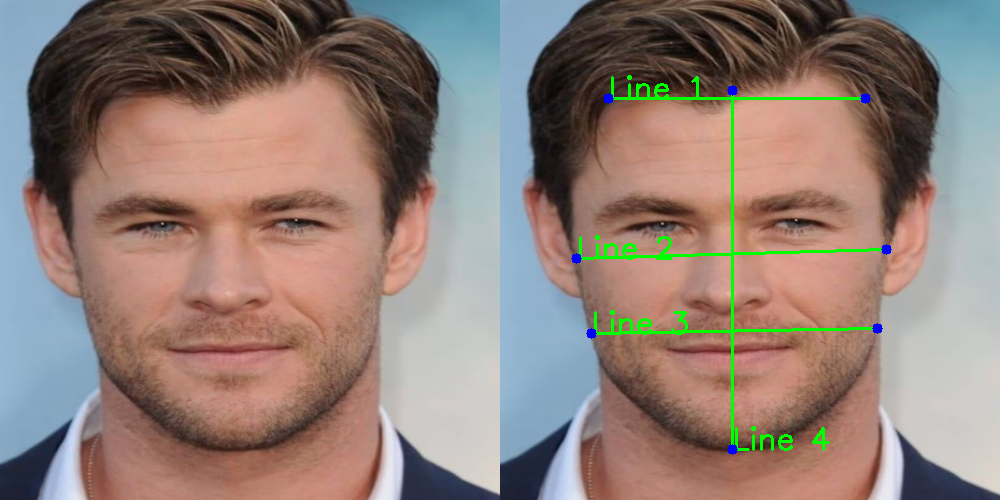

In [ ]:
import numpy as np #for mathematical calculations
import cv2 #for face detection and other image operations
import dlib #for detection of facial landmarks ex:nose,jawline,eyes
from sklearn.cluster import KMeans #for clustering
from google.colab.patches import cv2_imshow # for displaying images in Colab

# Load the image
imagepath = "/content/chrishemsworth.jpg"

face_cascade_path = "/content/haarcascade_frontalface_default.xml"
predictor_path = "/content/shape_predictor_68_face_landmarks.dat"

# Create the Haar cascade for detecting faces
faceCascade = cv2.CascadeClassifier(face_cascade_path)

# Create the landmark predictor
predictor = dlib.shape_predictor(predictor_path)

# Read the image
image = cv2.imread(imagepath)
image = cv2.resize(image, (500, 500))
original = image.copy()

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a Gaussian blur to remove noise
gauss = cv2.GaussianBlur(gray,(3,3), 0)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gauss,
    scaleFactor=1.05,
    minNeighbors=5,
    minSize=(100,100),
    flags=cv2.CASCADE_SCALE_IMAGE
)

print("found {0} faces!".format(len(faces)) )

for (x, y, w, h) in faces:
    # Draw a rectangle around the face
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Convert the OpenCV rectangle coordinates to Dlib rectangle
    dlib_rect = dlib.rectangle(int(x), int(y), int(x+w), int(y+h))

    # Detect landmarks
    detected_landmarks = predictor(image, dlib_rect).parts()

    # Convert to numpy matrix
    landmarks = np.matrix([[p.x, p.y] for p in detected_landmarks])

    results = original.copy()

    # Processing forehead region
    temp = original.copy()
    forehead = temp[y:y+int(0.25*h), x:x+w]
    rows, cols, bands = forehead.shape
    X = forehead.reshape(rows*cols, bands)

    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
    y_kmeans = kmeans.fit_predict(X)
    for i in range(rows):
        for j in range(cols):
            if y_kmeans[i*cols+j] == 1:
                forehead[i][j] = [255, 255, 255]
            else:
                forehead[i][j] = [0, 0, 0]

    # Calculate forehead width
    forehead_mid = [int(cols/2), int(rows/2)]
    lef = 0
    pixel_value = forehead[forehead_mid[1], forehead_mid[0]]
    for i in range(cols):
        if forehead[forehead_mid[1], forehead_mid[0]-i].all() != pixel_value.all():
            lef = forehead_mid[0]-i
            break
    left = [lef, forehead_mid[1]]
    rig = 0
    for i in range(cols):
        if forehead[forehead_mid[1], forehead_mid[0]+i].all() != pixel_value.all():
            rig = forehead_mid[0]+i
            break
    right = [rig, forehead_mid[1]]

    # Draw lines and circles
    line1 = np.subtract(right + x, left + x)[0]
    cv2.line(results, tuple(left + x), tuple(right + x), color=(0, 255, 0), thickness=2)
    cv2.putText(results, 'Line 1', tuple(left + x), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
    cv2.circle(results, tuple(left + x), 5, color=(255, 0, 0), thickness=-1)
    cv2.circle(results, tuple(right + x), 5, color=(255, 0, 0), thickness=-1)

    # Draw additional lines based on landmarks
    linepointleft = (landmarks[1, 0], landmarks[1, 1])
    linepointright = (landmarks[15, 0], landmarks[15, 1])
    line2 = np.subtract(linepointright, linepointleft)[0]
    cv2.line(results, linepointleft, linepointright, color=(0, 255, 0), thickness=2)
    cv2.putText(results, 'Line 2', linepointleft, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
    cv2.circle(results, linepointleft, 5, color=(255, 0, 0), thickness=-1)
    cv2.circle(results, linepointright, 5, color=(255, 0, 0), thickness=-1)

    linepointleft = (landmarks[3, 0], landmarks[3, 1])
    linepointright = (landmarks[13, 0], landmarks[13, 1])
    line3 = np.subtract(linepointright, linepointleft)[0]
    cv2.line(results, linepointleft, linepointright, color=(0, 255, 0), thickness=2)
    cv2.putText(results, 'Line 3', linepointleft, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
    cv2.circle(results, linepointleft, 5, color=(255, 0, 0), thickness=-1)
    cv2.circle(results, linepointright, 5, color=(255, 0, 0), thickness=-1)

    linepointbottom = (landmarks[8, 0], landmarks[8, 1])
    linepointtop = (landmarks[8, 0], y)
    line4 = np.subtract(linepointbottom, linepointtop)[1]
    cv2.line(results, linepointtop, linepointbottom, color=(0, 255, 0), thickness=2)
    cv2.putText(results, 'Line 4', linepointbottom, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
    cv2.circle(results, linepointtop, 5, color=(255, 0, 0), thickness=-1)
    cv2.circle(results, linepointbottom, 5, color=(255, 0, 0), thickness=-1)

    # Calculate similarity and angles
    similarity = np.std([line1, line2, line3])
    ovalsimilarity = np.std([line2, line4])

    ax, ay = landmarks[3, 0], landmarks[3, 1]
    bx, by = landmarks[4, 0], landmarks[4, 1]
    cx, cy = landmarks[5, 0], landmarks[5, 1]
    dx, dy = landmarks[6, 0], landmarks[6, 1]
    import math
    from math import degrees
    alpha0 = math.atan2(cy - ay, cx - ax)
    alpha1 = math.atan2(dy - by, dx - bx)
    alpha = alpha1 - alpha0
    angle = abs(degrees(alpha))
    angle = 180 - angle

    if similarity < 10:
        if angle < 160:
            print('squared shape. Jawlines are more angular')
        else:
            print('round shape. Jawlines are not that angular')
    elif line3 > line1:
        if angle < 160:
            print('triangle shape. Forehead is more wider')
        else:
            print('diamond shape. line2 & line4 are similar and line2 is slightly larger')
    elif ovalsimilarity < 10:
        print('diamond shape. line2 & line4 are similar and line2 is slightly larger')
    elif line4 > line2:
        if angle < 160:
            print('rectangular. face length is largest and jawline are angular ')
        else:
            print('oblong. face length is largest and jawlines are not angular')
    else:
        print("Damn! Contact the developer")

# Concatenate and display the results
output = np.concatenate((original, results), axis=1)
cv2_imshow(output)